**MLaaS Human Activity Recognisation**
---

In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')
# Define the paths to your datasets in Google Drive
import numpy as np
df= pd.read_csv("/content/drive/My Drive/Early Drift Detection/pamap2_final.csv")
df

Mounted at /content/drive


,Unnamed: 0,accelerometer_x,accelerometer_y,accelerometer_z,gyroscope_x,gyroscope_y,gyroscope_z,activity,accelerometer_x_mean,accelerometer_x_std,...,gyroscope_y_mad,gyroscope_y_max,gyroscope_y_min,gyroscope_y_sma,gyroscope_z_mean,gyroscope_z_std,gyroscope_z_mad,gyroscope_z_max,gyroscope_z_min,gyroscope_z_sma
0,49,2.021410,9.35812,3.04082,0.431367,-0.015620,-0.035577,2,2.149858,0.125227,...,0.031028,0.065358,-0.068942,1.547971,-0.009330,0.030435,0.017855,0.056646,-0.081657,1.185657
1,50,2.058940,9.31989,3.04151,0.338133,-0.016064,0.007478,2,2.148545,0.125828,...,0.028083,0.065358,-0.068942,1.539219,-0.008860,0.030509,0.015752,0.056646,-0.081657,1.177122
2,51,2.056530,9.16780,3.00350,0.304415,-0.051594,0.014247,2,2.142910,0.123493,...,0.028870,0.065358,-0.068942,1.579466,-0.008765,0.030574,0.016262,0.056646,-0.081657,1.181885
3,52,2.130510,9.12894,2.96625,0.267546,-0.024152,-0.027965,2,2.140975,0.122912,...,0.028597,0.065358,-0.068942,1.586518,-0.009189,0.030690,0.017087,0.056646,-0.081657,1.203080
4,53,2.056530,9.16780,3.00350,0.254874,0.011192,-0.042030,2,2.138305,0.123267,...,0.029001,0.065358,-0.068942,1.590529,-0.010143,0.030953,0.020325,0.056646,-0.081657,1.239417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746350,876674,0.489770,2.82383,9.23639,-0.017195,0.006944,0.007758,4,0.555574,0.179076,...,0.020872,0.098473,-0.038071,1.524133,0.010320,0.029036,0.017445,0.071230,-0.052905,1.307806
746351,876675,0.370253,2.70955,9.08103,-0.032333,-0.044224,0.011758,4,0.547796,0.178511,...,0.020872,0.098473,-0.044224,1.565673,0.011493,0.027862,0.017127,0.071230,-0.052905,1.272671
746352,876676,0.644139,2.70986,9.35454,-0.004483,-0.001148,0.039415,4,0.545582,0.176606,...,0.020872,0.098473,-0.044224,1.560528,0.012877,0.027494,0.017085,0.071230,-0.052905,1.282298
746353,876677,0.566153,2.74771,9.27627,-0.022839,0.045628,0.049042,4,0.545481,0.176592,...,0.020872,0.098473,-0.044224,1.575995,0.014334,0.027442,0.016784,0.071230,-0.052905,1.307547


In [ ]:
df['activity'].value_counts()

,count
activity,
1,186706
2,183461
3,161942
0,142834
4,71412


In [ ]:
activity_col = 'activity'   # adjust to your column name
total_samples = 300_000
# number of classes
n_classes = df[activity_col].nunique()
# number per class
samples_per_class = total_samples // n_classes  # 2,000 per class
# sample equally from each activity
balanced_df = (
    df.groupby(activity_col, group_keys=False)
      .apply(lambda x: x.sample(samples_per_class, random_state=42))
)
# check
print(balanced_df[activity_col].value_counts())
balanced_df.to_csv("balanced_10k.csv", index=False)

/tmp/ipython-input-674122431.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(samples_per_class, random_state=42))


activity
0    60000
1    60000
2    60000
3    60000
4    60000
Name: count, dtype: int64


In [ ]:
balanced_df['activity'].value_counts()

,count
activity,
0,60000
1,60000
2,60000
3,60000
4,60000


**Shuffe samples**

In [ ]:
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
# Check counts
print(balanced_df[activity_col].value_counts())

activity
0    60000
1    60000
4    60000
2    60000
3    60000
Name: count, dtype: int64


In [ ]:
df=balanced_df

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
# Step 1: Normalize activity labels to 0-based classes
unique_labels = sorted(df['activity'].unique())
label_map = {label: i for i, label in enumerate(unique_labels)}
df['activity'] = df['activity'].map(label_map)
# Step 2: Select features and target
features = ['accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'gyroscope_x',
       'gyroscope_y', 'gyroscope_z', 'accelerometer_x_mean',
       'accelerometer_x_std', 'accelerometer_x_mad', 'accelerometer_x_max',
       'accelerometer_x_min', 'accelerometer_x_sma', 'accelerometer_y_mean',
       'accelerometer_y_std', 'accelerometer_y_mad', 'accelerometer_y_max',
       'accelerometer_y_min', 'accelerometer_y_sma', 'accelerometer_z_mean',
       'accelerometer_z_std', 'accelerometer_z_mad', 'accelerometer_z_max',
       'accelerometer_z_min', 'accelerometer_z_sma', 'gyroscope_x_mean',
       'gyroscope_x_std', 'gyroscope_x_mad', 'gyroscope_x_max',
       'gyroscope_x_min', 'gyroscope_x_sma', 'gyroscope_y_mean',
       'gyroscope_y_std', 'gyroscope_y_mad', 'gyroscope_y_max',
       'gyroscope_y_min', 'gyroscope_y_sma', 'gyroscope_z_mean',
       'gyroscope_z_std', 'gyroscope_z_mad', 'gyroscope_z_max',
       'gyroscope_z_min', 'gyroscope_z_sma']
target = 'activity'
# Step 3: Train-test split
X = df[features].values
y = df[target].values
# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)
#joblib.dump(scaler, '/content/drive/My Drive/Early Drift Detection/scaler.pkl')
# Reshape for CNN: (samples, time_steps=6, channels=1)
X = X.reshape(-1, len(features), 1)
# One-hot encode target
num_classes = len(unique_labels)
y_cat = to_categorical(y, num_classes)
#joblib.dump(label_encoder, 'label_encoder.pkl')
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)
# Step 4: Build CNN model
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', padding='same', input_shape=(len(features), 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Step 5: Train
model.fit(X_train, y_train, validation_split=0.2, epochs=5, batch_size=64)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 59s 19ms/step - accuracy: 0.8843 - loss: 0.3796 - val_accuracy: 0.9205 - val_loss: 0.2292
Epoch 2/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 56s 19ms/step - accuracy: 0.9232 - loss: 0.2310 - val_accuracy: 0.9369 - val_loss: 0.1804
Epoch 3/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 78s 17ms/step - accuracy: 0.9345 - loss: 0.1938 - val_accuracy: 0.9480 - val_loss: 0.1487
Epoch 4/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 84s 18ms/step - accuracy: 0.9421 - loss: 0.1661 - val_accuracy: 0.9536 - val_loss: 0.1336
Epoch 5/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 79s 17ms/step - accuracy: 0.9472 - loss: 0.1470 - val_accuracy: 0.9583 - val_loss: 0.1126


**Concept Drift Setup**
---

In [8]:
X_test.shape

(60000, 42, 1)

In [9]:
X_test = X_test.reshape(-1, len(features))
X_test

array([[-0.06215054, -0.30151181,  0.72023266, ..., -0.51811631,
         0.56656361, -0.69324192],
       [ 0.11542841,  0.15179094, -1.75567856, ...,  0.37648768,
         0.37398886,  0.06776205],
       [ 0.90375528, -0.5418309 ,  2.09722015, ..., -0.13435605,
         0.45433112, -0.42130516],
       ...,
       [-0.31933275, -0.0419039 ,  0.22737699, ..., -0.72152312,
         0.64869895, -0.80293095],
       [ 0.22952734, -0.39014806,  0.99848031, ..., -0.60797928,
         0.56507281, -0.7105944 ],
       [ 0.60812031,  0.17991289,  1.05969319, ..., -0.67608674,
         0.66382755, -0.78654766]])

In [10]:
y_test

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]])

In [11]:
import pandas as pd
import numpy as np

# Your array (example: X)
# X = np.array([...])  # already exists in your case

# Column names
columns = ['accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'gyroscope_x',
           'gyroscope_y', 'gyroscope_z', 'accelerometer_x_mean',
           'accelerometer_x_std', 'accelerometer_x_mad', 'accelerometer_x_max',
           'accelerometer_x_min', 'accelerometer_x_sma', 'accelerometer_y_mean',
           'accelerometer_y_std', 'accelerometer_y_mad', 'accelerometer_y_max',
           'accelerometer_y_min', 'accelerometer_y_sma', 'accelerometer_z_mean',
           'accelerometer_z_std', 'accelerometer_z_mad', 'accelerometer_z_max',
           'accelerometer_z_min', 'accelerometer_z_sma', 'gyroscope_x_mean',
           'gyroscope_x_std', 'gyroscope_x_mad', 'gyroscope_x_max',
           'gyroscope_x_min', 'gyroscope_x_sma', 'gyroscope_y_mean',
           'gyroscope_y_std', 'gyroscope_y_mad', 'gyroscope_y_max',
           'gyroscope_y_min', 'gyroscope_y_sma', 'gyroscope_z_mean',
           'gyroscope_z_std', 'gyroscope_z_mad', 'gyroscope_z_max',
           'gyroscope_z_min', 'gyroscope_z_sma']

# Convert to DataFrame
X_test = pd.DataFrame(X_test, columns=columns)
X_test

,accelerometer_x,accelerometer_y,accelerometer_z,gyroscope_x,gyroscope_y,gyroscope_z,accelerometer_x_mean,accelerometer_x_std,accelerometer_x_mad,accelerometer_x_max,...,gyroscope_y_mad,gyroscope_y_max,gyroscope_y_min,gyroscope_y_sma,gyroscope_z_mean,gyroscope_z_std,gyroscope_z_mad,gyroscope_z_max,gyroscope_z_min,gyroscope_z_sma
0,-0.062151,-0.301512,0.720233,-0.038716,0.145030,-0.116744,0.356526,-0.197117,-0.279055,0.074613,...,-0.514715,-0.416326,0.493654,-0.623404,0.070705,-0.612909,-0.559886,-0.518116,0.566564,-0.693242
1,0.115428,0.151791,-1.755679,-2.243616,1.688797,0.772328,-0.523168,-0.326328,-0.576586,-0.543317,...,-0.490723,0.579645,0.645855,-0.161216,0.633761,0.146550,0.304989,0.376488,0.373989,0.067762
2,0.903755,-0.541831,2.097220,0.239105,-0.631559,0.548052,-0.025424,0.852914,0.893061,1.182263,...,0.170823,-0.074923,-0.694472,-0.015511,0.387750,-0.408569,-0.425055,-0.134356,0.454331,-0.421305
3,-1.243512,-0.434802,-0.361421,-0.557387,-0.400271,-0.609705,-1.286939,-0.093760,-0.036697,-1.059074,...,0.582095,1.413927,0.441865,1.220891,1.990336,0.137288,-0.046625,0.906588,0.196947,0.788000
4,-0.330780,-0.035040,-0.080267,-0.017015,-0.026695,0.028357,-0.524752,-0.698768,-0.687863,-1.031876,...,-0.677682,-0.675843,0.745672,-0.790546,-0.023442,-0.734340,-0.674400,-0.721773,0.661322,-0.810845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.557755,-1.129075,0.761236,-0.043621,-0.074405,0.018387,0.921577,-0.701506,-0.682775,-0.127684,...,-0.684320,-0.681584,0.761342,-0.794282,-0.016763,-0.733855,-0.672965,-0.713343,0.668644,-0.811729
59996,-1.525760,-0.135729,-0.007843,-0.170920,-0.429152,0.346962,-0.878257,-0.178919,-0.219808,-0.815239,...,-0.507788,-0.107334,0.413116,-0.123984,-1.239974,-0.157502,-0.366559,-0.459160,-0.264294,0.160953
59997,-0.319333,-0.041904,0.227377,-0.068098,-0.100612,-0.007199,-0.451486,-0.697648,-0.686646,-0.981895,...,-0.682689,-0.689261,0.728645,-0.785989,-0.035101,-0.728395,-0.671237,-0.721523,0.648699,-0.802931
59998,0.229527,-0.390148,0.998480,-0.020637,-0.117322,-0.035777,0.180712,-0.332152,-0.253628,-0.137358,...,-0.482139,-0.503012,0.549200,-0.612284,-0.089804,-0.635867,-0.570966,-0.607979,0.565073,-0.710594


In [12]:
import numpy as np
import pandas as pd
# Step 1: Reload original data
XTest = X_test.copy()
activity_labels = np.argmax(y_test, axis=1)
# Add to XTest DataFrame
XTest['activity'] = activity_labels

In [13]:
XTest['activity'].value_counts()

,count
activity,
2,12080
3,12041
1,12014
0,11963
4,11902


In [14]:
XTest.columns

Index(['accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'gyroscope_x',
       'gyroscope_y', 'gyroscope_z', 'accelerometer_x_mean',
       'accelerometer_x_std', 'accelerometer_x_mad', 'accelerometer_x_max',
       'accelerometer_x_min', 'accelerometer_x_sma', 'accelerometer_y_mean',
       'accelerometer_y_std', 'accelerometer_y_mad', 'accelerometer_y_max',
       'accelerometer_y_min', 'accelerometer_y_sma', 'accelerometer_z_mean',
       'accelerometer_z_std', 'accelerometer_z_mad', 'accelerometer_z_max',
       'accelerometer_z_min', 'accelerometer_z_sma', 'gyroscope_x_mean',
       'gyroscope_x_std', 'gyroscope_x_mad', 'gyroscope_x_max',
       'gyroscope_x_min', 'gyroscope_x_sma', 'gyroscope_y_mean',
       'gyroscope_y_std', 'gyroscope_y_mad', 'gyroscope_y_max',
       'gyroscope_y_min', 'gyroscope_y_sma', 'gyroscope_z_mean',
       'gyroscope_z_std', 'gyroscope_z_mad', 'gyroscope_z_max',
       'gyroscope_z_min', 'gyroscope_z_sma', 'activity'],
      dtype='object')

In [15]:
XTest.to_csv("drift.csv", index=False)

**Bullet points:**
*   **Original Dataset (O)**: Original HAR dataset without any modifications. Used as the baseline signature to compare against all drifted scenarios
*   **Abrupt Drift (A)**: Sudden and complete change in both feature distribution and activity labels within specific segments as the baseline signature to compare against all drifted scenarios.
* **Incremental Drift (I)**: Stepwise introduction of new concepts or activity patterns, changing a small portion of the data at a time. Mimics slowly evolving contexts, e.g., incremental addition of new user behaviors or devices.
* **Recurrent Drift (R)**: Alternating between original and altered concepts in different segments, returning periodically to previous states. Captures recurring patterns where earlier conditions reappear, such as daily routines or repeated sensor contexts.

In [16]:
import pandas as pd
import numpy as np

# ---------- IO ----------
def load_data(path):
    """Load dataset with features and label in last column."""
    df = pd.read_csv(path)
    X = df.iloc[:, :-1].copy()
    y = df.iloc[:, -1].copy()
    return X, y

def _return_with_label_last(X_new, y_new):
    out = X_new.copy()
    out[y_new.name] = y_new.values
    return out

# ---------- SUDDEN DRIFT — TYPE 1 (USING ABSOLUTE SAMPLE COUNTS) ----------
def sudden_drift_type1_delayed_abrupt(
    X, y,
    *, clean_samples=5000,        # <<< FIXED: Absolute number of clean samples
    corruption_samples=None,      # <<< FIXED: Absolute number of corrupted samples
    corruption_rate=1.0, shuffle_X=True, random_state=None
):
    """
    FIXED: Uses ABSOLUTE sample counts instead of percentages
    clean_samples: Number of samples to keep clean from the start
    corruption_samples: Number of samples to corrupt after clean_samples (default: all remaining)
    """
    rng = np.random.default_rng(random_state)
    n = len(y)
    X_new, y_new = X.copy(), y.copy()
    classes = y.unique()

    # Calculate corruption range
    start_corrupt = clean_samples
    if corruption_samples is None:
        end_corrupt = n  # Corrupt all remaining samples
    else:
        end_corrupt = min(n, start_corrupt + corruption_samples)

    if start_corrupt < n:
        tail_idx = np.arange(start_corrupt, end_corrupt)
        if corruption_rate >= 1.0:
            sel_idx = tail_idx
        else:
            mask = rng.random(len(tail_idx)) < float(corruption_rate)
            sel_idx = tail_idx[mask]

        if len(sel_idx) > 0:
            # STRONG label corruption for specified samples
            for idx in sel_idx:
                true_class = y_new.iloc[idx]
                wrong_classes = [c for c in classes if c != true_class]
                if wrong_classes:
                    y_new.iloc[idx] = rng.choice(wrong_classes)

            # STRONG feature corruption for specified samples
            if shuffle_X:
                for col in X.columns:
                    if X[col].dtype in ['float64', 'int64']:
                        original_vals = X_new[col].iloc[sel_idx].values
                        # Massive corruption: large noise + mean shift
                        noise = rng.normal(0, 5 * original_vals.std(), len(sel_idx))
                        shift = 4 * original_vals.std() * rng.choice([-1, 1])
                        X_new[col].iloc[sel_idx] = original_vals + noise + shift
                    else:
                        # Complete categorical scrambling
                        unique_vals = X[col].unique()
                        new_vals = rng.choice(unique_vals, size=len(sel_idx), replace=True)
                        X_new[col].iloc[sel_idx] = new_vals

    print(f"SUDDEN TYPE 1 FIXED: First {start_corrupt} samples CLEAN -> Samples {start_corrupt} to {end_corrupt} STRONGLY CORRUPTED")
    return _return_with_label_last(X_new, y_new)

# ---------- SUDDEN DRIFT — TYPE 2 (USING ABSOLUTE SAMPLE COUNTS) ----------
def sudden_drift_type2_abrupt_then_recover(
    X, y,
    *, corrupt_samples=5000,      # <<< FIXED: Absolute number of corrupted samples
    recovery_samples=5000,        # <<< FIXED: Absolute number of recovery samples
    start_rate=1.0, end_rate=0.0,
    decay_shape=0.7,
    shuffle_X=True, random_state=None
):
    """
    FIXED: Uses ABSOLUTE sample counts instead of percentages
    corrupt_samples: Number of samples to fully corrupt from the start
    recovery_samples: Number of samples for gradual recovery phase
    """
    rng = np.random.default_rng(random_state)
    n = len(y)
    X_new, y_new = X.copy(), y.copy()
    classes = y.unique()

    # Calculate ranges using absolute counts
    corrupt_end = min(n, corrupt_samples)
    recovery_end = min(n, corrupt_end + recovery_samples)

    # Build per-index corruption probability vector
    p = np.zeros(n, dtype=float)

    # 1) INITIAL CORRUPTION: First X samples fully corrupted
    if corrupt_end > 0:
        p[:corrupt_end] = float(start_rate)

    # 2) GRADUAL RECOVERY: Next Y samples gradual recovery
    if recovery_end > corrupt_end:
        recovery_length = recovery_end - corrupt_end
        t = np.linspace(0.0, 1.0, recovery_length, endpoint=True)
        # Gradual decay from full corruption to clean
        p[corrupt_end:recovery_end] = end_rate + (start_rate - end_rate) * (1.0 - t**decay_shape)

    # 3) REMAINING SAMPLES: Clean (p=0)

    # Sample indices to corrupt by probability p
    mask = rng.random(n) < p
    sel_idx = np.where(mask)[0]

    if len(sel_idx) > 0:
        # Apply corruption based on probability
        for idx in sel_idx:
            true_class = y_new.iloc[idx]
            wrong_classes = [c for c in classes if c != true_class]
            if wrong_classes:
                y_new.iloc[idx] = rng.choice(wrong_classes)

        # Feature corruption intensity based on corruption probability
        if shuffle_X:
            for col in X.columns:
                if X[col].dtype in ['float64', 'int64']:
                    for idx in sel_idx:
                        corruption_strength = p[idx]  # Strength based on position
                        original_val = X_new[col].iloc[idx]
                        noise = rng.normal(0, 4 * corruption_strength * X[col].std())
                        shift = 3 * corruption_strength * X[col].std() * rng.choice([-1, 1])
                        X_new[col].iloc[idx] = original_val + noise + shift
                else:
                    # For categorical features in fully corrupted region
                    if idx < corrupt_end:
                        unique_vals = X[col].unique()
                        new_val = rng.choice(unique_vals)
                        X_new[col].iloc[idx] = new_val

    print(f"SUDDEN TYPE 2 FIXED: First {corrupt_end} samples CORRUPTED -> Next {recovery_length} samples GRADUAL RECOVERY -> Last {n-recovery_end} samples CLEAN")
    return _return_with_label_last(X_new, y_new)

# ---------- RECURRENT DRIFT (USING ABSOLUTE SAMPLE COUNTS) ----------
def recurrent_drift(X, y, segment_samples=400, *, shuffle_X=True, random_state=None):
    """
    FIXED: Uses absolute sample count for segment size
    segment_samples: Number of samples in each segment (clean/corrupt alternate)
    """
    rng = np.random.default_rng(random_state)
    n = len(y)
    n_segments = (n + segment_samples - 1) // segment_samples
    X_new, y_new = X.copy(), y.copy()
    classes = y.unique()

    for i in range(n_segments):
        s = i * segment_samples
        e = min((i + 1) * segment_samples, n)

        if i % 2 == 1:  # CORRUPTED BLOCK
            # High percentage label corruption
            corrupt_indices = rng.choice(np.arange(s, e), size=int(0.85 * (e-s)), replace=False)
            for idx in corrupt_indices:
                true_class = y_new.iloc[idx]
                wrong_classes = [c for c in classes if c != true_class]
                if wrong_classes:
                    y_new.iloc[idx] = rng.choice(wrong_classes)

            # Strong feature corruption
            if shuffle_X:
                for col in X.columns:
                    if X[col].dtype in ['float64', 'int64']:
                        original_vals = X_new[col].iloc[s:e].values
                        noise = rng.normal(0, 6 * original_vals.std(), e-s)
                        shift = 5 * original_vals.std() * rng.choice([-1, 1])
                        X_new[col].iloc[s:e] = original_vals + noise + shift
                    else:
                        unique_vals = X[col].unique()
                        new_vals = rng.choice(unique_vals, size=(e-s), replace=True)
                        X_new[col].iloc[s:e] = new_vals

            print(f"RECURRENT: Segment {i} ({s}-{e}) CORRUPTED")

        else:  # CLEAN BLOCK
            # Leave completely unchanged for perfect accuracy
            X_new.iloc[s:e] = X.iloc[s:e].to_numpy(copy=True)
            y_new.iloc[s:e] = y.iloc[s:e].to_numpy(copy=True)
            print(f"RECURRENT: Segment {i} ({s}-{e}) CLEAN")

    return _return_with_label_last(X_new, y_new)

# ---------- USAGE ----------
if __name__ == "__main__":
    file_path = "drift.csv"
    X, y = load_data(file_path)
    n_total = len(y)
    print(f"Total samples: {n_total}")

    # pristine
    df_nodrift = _return_with_label_last(X, y)
    df_nodrift.to_csv("har_no_drift.csv", index=False)

    # Sudden Type 1: First 5000 CLEAN -> Next 5000 CORRUPTED
    df_sudden_type1 = sudden_drift_type1_delayed_abrupt(
        X, y,
        clean_samples=5000,        # First 5000 samples clean
        corruption_samples=5000,   # Next 5000 samples corrupted
        corruption_rate=1.0,
        shuffle_X=True,
        random_state=42
    )

    # Sudden Type 2: First 5000 CORRUPTED -> Next 5000 RECOVERY
    df_sudden_type2 = sudden_drift_type2_abrupt_then_recover(
        X, y,
        corrupt_samples=5000,      # First 5000 samples corrupted
        recovery_samples=5000,     # Next 5000 samples gradual recovery
        start_rate=1.0,
        end_rate=0.0,
        decay_shape=0.7,
        shuffle_X=True,
        random_state=42
    )

    # Recurrent: Alternating every 400 samples
    df_recurrent = recurrent_drift(
        X, y,
        segment_samples=400,       # Each segment = 400 samples
        shuffle_X=True,
        random_state=42
    )

    # Save datasets
    df_sudden_type1.to_csv("har_sudden_drift_type1_delayed_abrupt.csv", index=False)
    df_sudden_type2.to_csv("har_sudden_drift_type2_abrupt_recover.csv", index=False)
    df_recurrent.to_csv("har_recurrent_drift.csv", index=False)

    print("\n=== PRECISE DRIFT PATTERNS (ABSOLUTE COUNTS) ===")
    print("Sudden Type 1: Samples 0-4999 CLEAN -> Samples 5000-9999 CORRUPTED")
    print("Sudden Type 2: Samples 0-4999 CORRUPTED -> Samples 5000-9999 GRADUAL RECOVERY")
    print("Recurrent: Alternating CLEAN/CORRUPTED every 400 samples")
    print("All datasets saved successfully!")

Total samples: 60000


/tmp/ipython-input-2577008287.py:65: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  X_new[col].iloc[sel_idx] = original_vals + noise + shift


SUDDEN TYPE 1 FIXED: First 5000 samples CLEAN -> Samples 5000 to 10000 STRONGLY CORRUPTED


/tmp/ipython-input-2577008287.py:135: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  X_new[col].iloc[idx] = original_val + noise + shift


SUDDEN TYPE 2 FIXED: First 5000 samples CORRUPTED -> Next 5000 samples GRADUAL RECOVERY -> Last 50000 samples CLEAN
RECURRENT: Segment 0 (0-400) CLEAN
RECURRENT: Segment 1 (400-800) CORRUPTED
RECURRENT: Segment 2 (800-1200) CLEAN
RECURRENT: Segment 3 (1200-1600) CORRUPTED
RECURRENT: Segment 4 (1600-2000) CLEAN
RECURRENT: Segment 5 (2000-2400) CORRUPTED
RECURRENT: Segment 6 (2400-2800) CLEAN


/tmp/ipython-input-2577008287.py:178: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  X_new[col].iloc[s:e] = original_vals + noise + shift


RECURRENT: Segment 7 (2800-3200) CORRUPTED
RECURRENT: Segment 8 (3200-3600) CLEAN
RECURRENT: Segment 9 (3600-4000) CORRUPTED
RECURRENT: Segment 10 (4000-4400) CLEAN
RECURRENT: Segment 11 (4400-4800) CORRUPTED
RECURRENT: Segment 12 (4800-5200) CLEAN
RECURRENT: Segment 13 (5200-5600) CORRUPTED
RECURRENT: Segment 14 (5600-6000) CLEAN
RECURRENT: Segment 15 (6000-6400) CORRUPTED
RECURRENT: Segment 16 (6400-6800) CLEAN
RECURRENT: Segment 17 (6800-7200) CORRUPTED
RECURRENT: Segment 18 (7200-7600) CLEAN
RECURRENT: Segment 19 (7600-8000) CORRUPTED
RECURRENT: Segment 20 (8000-8400) CLEAN
RECURRENT: Segment 21 (8400-8800) CORRUPTED
RECURRENT: Segment 22 (8800-9200) CLEAN
RECURRENT: Segment 23 (9200-9600) CORRUPTED
RECURRENT: Segment 24 (9600-10000) CLEAN
RECURRENT: Segment 25 (10000-10400) CORRUPTED
RECURRENT: Segment 26 (10400-10800) CLEAN
RECURRENT: Segment 27 (10800-11200) CORRUPTED
RECURRENT: Segment 28 (11200-11600) CLEAN
RECURRENT: Segment 29 (11600-12000) CORRUPTED
RECURRENT: Segment 30 (1

In [ ]:
import pandas as pd

# Load the datasets
df_sudden_type1 = pd.read_csv("/content/har_sudden_drift_type1_delayed_abrupt.csv")
df_sudden_type2 = pd.read_csv("/content/har_sudden_drift_type2_abrupt_recover.csv")
df_recurrent    = pd.read_csv("har_recurrent_drift.csv")
df_nodrift      = pd.read_csv("har_no_drift.csv")

# Add a column to identify the drift type
df_sudden_type1["drift_type"] = "sudden_type1"
df_sudden_type2["drift_type"] = "sudden_type2"
df_recurrent["drift_type"]    = "recurrent"
df_nodrift["drift_type"]      = "nodrift"

# Concatenate into a single DataFrame
df_merged = pd.concat(
    [df_sudden_type1, df_sudden_type2, df_recurrent, df_nodrift],
    ignore_index=True
)

# Save merged dataset
df_merged.to_csv("har_all_drifts.csv", index=False)

print("Merged dataset saved to 'har_all_drifts.csv'")

In [ ]:
df_sudden_type1.columns

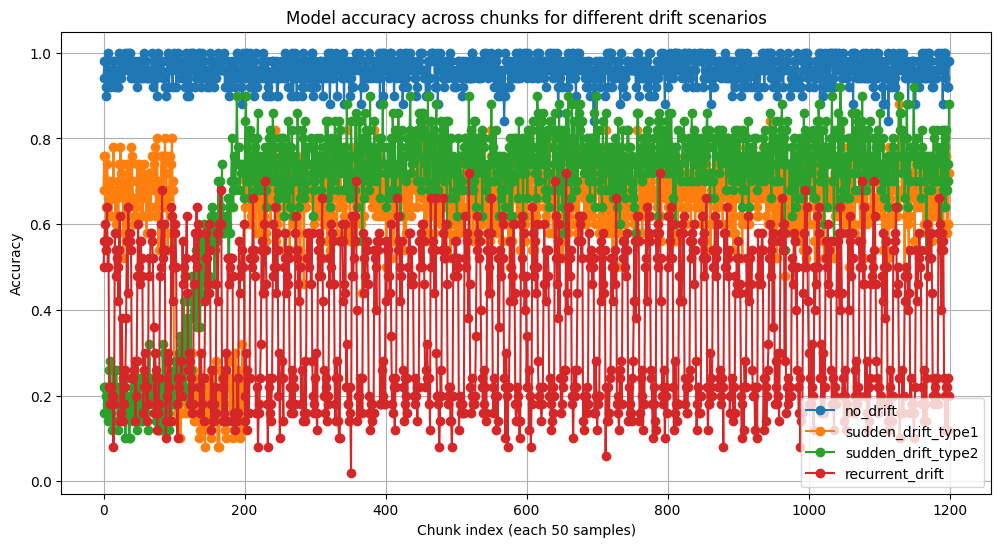

In [19]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Correct dataset dictionary names
datasets = {
    "no_drift": df_nodrift,
    "sudden_drift_type1": df_sudden_type1,
    "sudden_drift_type2": df_sudden_type2,
    "recurrent_drift": df_recurrent,
}

features = [
    'accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'gyroscope_x',
    'gyroscope_y', 'gyroscope_z', 'accelerometer_x_mean', 'accelerometer_x_std',
    'accelerometer_x_mad', 'accelerometer_x_max', 'accelerometer_x_min',
    'accelerometer_x_sma', 'accelerometer_y_mean', 'accelerometer_y_std',
    'accelerometer_y_mad', 'accelerometer_y_max', 'accelerometer_y_min',
    'accelerometer_y_sma', 'accelerometer_z_mean', 'accelerometer_z_std',
    'accelerometer_z_mad', 'accelerometer_z_max', 'accelerometer_z_min',
    'accelerometer_z_sma', 'gyroscope_x_mean', 'gyroscope_x_std',
    'gyroscope_x_mad', 'gyroscope_x_max', 'gyroscope_x_min', 'gyroscope_x_sma',
    'gyroscope_y_mean', 'gyroscope_y_std', 'gyroscope_y_mad', 'gyroscope_y_max',
    'gyroscope_y_min', 'gyroscope_y_sma', 'gyroscope_z_mean', 'gyroscope_z_std',
    'gyroscope_z_mad', 'gyroscope_z_max', 'gyroscope_z_min', 'gyroscope_z_sma'
]
target = 'activity'

scaler = StandardScaler()
chunk_size = 50  # samples per evaluation chunk

plt.figure(figsize=(12,6))

for name, df_mod in datasets.items():
    X = df_mod[features].values
    y = df_mod[target].values

    # Scale features
    X_scaled = scaler.fit_transform(X)
    X_scaled = X_scaled.reshape(-1, len(features), 1)

    # One-hot encode labels
    num_classes = len(np.unique(y))
    y_categorical = to_categorical(y, num_classes=num_classes)

    # Evaluate in chunks
    n_samples = X_scaled.shape[0]
    n_chunks = n_samples // chunk_size
    accs = []

    for i in range(n_chunks):
        start, end = i * chunk_size, (i + 1) * chunk_size
        X_chunk, y_chunk = X_scaled[start:end], y_categorical[start:end]
        if len(X_chunk) == 0:
            continue
        loss, accuracy = model.evaluate(X_chunk, y_chunk, verbose=0)
        accs.append(accuracy)

    plt.plot(range(len(accs)), accs, marker='o', label=name)

plt.title("Model accuracy across chunks for different drift scenarios")
plt.xlabel(f"Chunk index (each {chunk_size} samples)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


**Client Side Early Perfromace Drift Detction**
---

**Data Monitor**
---

In [20]:
df_sudden_type1

,accelerometer_x,accelerometer_y,accelerometer_z,gyroscope_x,gyroscope_y,gyroscope_z,accelerometer_x_mean,accelerometer_x_std,accelerometer_x_mad,accelerometer_x_max,...,gyroscope_y_min,gyroscope_y_sma,gyroscope_z_mean,gyroscope_z_std,gyroscope_z_mad,gyroscope_z_max,gyroscope_z_min,gyroscope_z_sma,activity,drift_type
0,-0.062151,-0.301512,0.720233,-0.038716,0.145030,-0.116744,0.356526,-0.197117,-0.279055,0.074613,...,0.493654,-0.623404,0.070705,-0.612909,-0.559886,-0.518116,0.566564,-0.693242,3,sudden_type1
1,0.115428,0.151791,-1.755679,-2.243616,1.688797,0.772328,-0.523168,-0.326328,-0.576586,-0.543317,...,0.645855,-0.161216,0.633761,0.146550,0.304989,0.376488,0.373989,0.067762,0,sudden_type1
2,0.903755,-0.541831,2.097220,0.239105,-0.631559,0.548052,-0.025424,0.852914,0.893061,1.182263,...,-0.694472,-0.015511,0.387750,-0.408569,-0.425055,-0.134356,0.454331,-0.421305,3,sudden_type1
3,-1.243512,-0.434802,-0.361421,-0.557387,-0.400271,-0.609705,-1.286939,-0.093760,-0.036697,-1.059074,...,0.441865,1.220891,1.990336,0.137288,-0.046625,0.906588,0.196947,0.788000,0,sudden_type1
4,-0.330780,-0.035040,-0.080267,-0.017015,-0.026695,0.028357,-0.524752,-0.698768,-0.687863,-1.031876,...,0.745672,-0.790546,-0.023442,-0.734340,-0.674400,-0.721773,0.661322,-0.810845,1,sudden_type1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.557755,-1.129075,0.761236,-0.043621,-0.074405,0.018387,0.921577,-0.701506,-0.682775,-0.127684,...,0.761342,-0.794282,-0.016763,-0.733855,-0.672965,-0.713343,0.668644,-0.811729,2,sudden_type1
59996,-1.525760,-0.135729,-0.007843,-0.170920,-0.429152,0.346962,-0.878257,-0.178919,-0.219808,-0.815239,...,0.413116,-0.123984,-1.239974,-0.157502,-0.366559,-0.459160,-0.264294,0.160953,0,sudden_type1
59997,-0.319333,-0.041904,0.227377,-0.068098,-0.100612,-0.007199,-0.451486,-0.697648,-0.686646,-0.981895,...,0.728645,-0.785989,-0.035101,-0.728395,-0.671237,-0.721523,0.648699,-0.802931,1,sudden_type1
59998,0.229527,-0.390148,0.998480,-0.020637,-0.117322,-0.035777,0.180712,-0.332152,-0.253628,-0.137358,...,0.549200,-0.612284,-0.089804,-0.635867,-0.570966,-0.607979,0.565073,-0.710594,3,sudden_type1


In [21]:
features = ['accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'gyroscope_x',
       'gyroscope_y', 'gyroscope_z', 'accelerometer_x_mean',
       'accelerometer_x_std', 'accelerometer_x_mad', 'accelerometer_x_max',
       'accelerometer_x_min', 'accelerometer_x_sma', 'accelerometer_y_mean',
       'accelerometer_y_std', 'accelerometer_y_mad', 'accelerometer_y_max',
       'accelerometer_y_min', 'accelerometer_y_sma', 'accelerometer_z_mean',
       'accelerometer_z_std', 'accelerometer_z_mad', 'accelerometer_z_max',
       'accelerometer_z_min', 'accelerometer_z_sma', 'gyroscope_x_mean',
       'gyroscope_x_std', 'gyroscope_x_mad', 'gyroscope_x_max',
       'gyroscope_x_min', 'gyroscope_x_sma', 'gyroscope_y_mean',
       'gyroscope_y_std', 'gyroscope_y_mad', 'gyroscope_y_max',
       'gyroscope_y_min', 'gyroscope_y_sma', 'gyroscope_z_mean',
       'gyroscope_z_std', 'gyroscope_z_mad', 'gyroscope_z_max',
       'gyroscope_z_min', 'gyroscope_z_sma']
target = 'activity'

# Step 3: Train-test split
X = df_sudden_type1[features].values
y= df_sudden_type1[target].values

# Normalize features
X = scaler.fit_transform(X)
#joblib.dump(scaler, '/content/drive/My Drive/Early Drift Detection/scaler.pkl')
# Reshape for CNN: (samples, time_steps=6, channels=1)
X = X.reshape(-1, len(features), 1)
# One-hot encode target
#num_classes = len(unique_labels)
#y_cat = to_categorical(y, num_classes)
y = y.reshape(-1, 1)
y_categorical = to_categorical(y, num_classes=5)
# Evaluate model
loss, accuracy = model.evaluate(X, y_categorical)
print(f"Test Accuracy: {accuracy:.4f}")

# Predict
y_pred_probs = model.predict(X)
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # numeric classes

# Flatten X back to original feature shape
X_flat = X.reshape(X.shape[0], X.shape[1])

# Build DataFrame with features + true label + prediction
df_results = pd.DataFrame(X_flat, columns=features)
df_results['true_activity'] = y.flatten()
df_results['predicted_activity'] = y_pred_classes

# Save if needed
df_results.to_csv('predictions_with_features.csv', index=False)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.5892 - loss: 5.8033
Test Accuracy: 0.6311
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


In [22]:
df_results

,accelerometer_x,accelerometer_y,accelerometer_z,gyroscope_x,gyroscope_y,gyroscope_z,accelerometer_x_mean,accelerometer_x_std,accelerometer_x_mad,accelerometer_x_max,...,gyroscope_y_min,gyroscope_y_sma,gyroscope_z_mean,gyroscope_z_std,gyroscope_z_mad,gyroscope_z_max,gyroscope_z_min,gyroscope_z_sma,true_activity,predicted_activity
0,-0.191673,-0.302848,0.178225,-0.183398,0.226662,-0.214533,0.331286,-0.249996,-0.297491,0.198952,...,0.398144,-0.457345,0.195605,-0.127140,-0.110428,-0.408741,0.434852,-0.170774,3,3
1,-0.105961,-0.081996,-0.998474,-1.241250,0.985232,0.208680,-0.092212,-0.312117,-0.443090,-0.096399,...,0.472117,-0.238593,0.460691,0.231123,0.310718,0.019775,0.342172,0.193686,0,0
2,0.274543,-0.419934,0.832650,-0.050108,-0.154935,0.101921,0.147410,0.254831,0.276093,0.728373,...,-0.179306,-0.169632,0.344870,-0.030746,-0.044773,-0.224920,0.380838,-0.040538,3,3
3,-0.761884,-0.367788,-0.335841,-0.432243,-0.041286,-0.449191,-0.459903,-0.200305,-0.178891,-0.342913,...,0.372974,0.415553,1.099366,0.226754,0.139501,0.273693,0.256967,0.538621,0,0
4,-0.321334,-0.173021,-0.202220,-0.172987,0.142281,-0.145463,-0.092975,-0.491177,-0.497544,-0.329914,...,0.520629,-0.536452,0.151281,-0.184423,-0.166190,-0.506293,0.480456,-0.227096,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.107538,-0.706043,0.197712,-0.185752,0.118837,-0.150209,0.603310,-0.492493,-0.495054,0.102261,...,0.528246,-0.538221,0.154425,-0.184195,-0.165491,-0.502255,0.483980,-0.227520,2,1
59996,-0.898118,-0.222078,-0.167800,-0.246826,-0.055477,0.006199,-0.263157,-0.241247,-0.268498,-0.226368,...,0.359001,-0.220971,-0.421461,0.087691,-0.016289,-0.380501,0.034987,0.238317,0,0
59997,-0.315808,-0.176365,-0.056009,-0.197495,0.105960,-0.162388,-0.057703,-0.490638,-0.496948,-0.306025,...,0.512354,-0.534296,0.145792,-0.181619,-0.164650,-0.506173,0.474381,-0.223306,1,0
59998,-0.050888,-0.346033,0.310464,-0.174725,0.097749,-0.175991,0.246646,-0.314917,-0.285048,0.097637,...,0.425141,-0.452082,0.120038,-0.137970,-0.115824,-0.451786,0.434134,-0.179084,3,3


**MLaaS Extraction Using Surrage Model**
---

Surrogate accuracy vs. black-box predictions: 0.7717


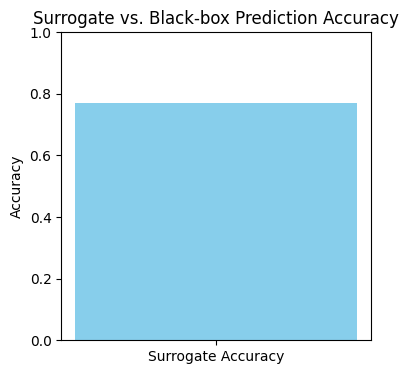

In [23]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# X = features, y_surrogate = black-box predictions
X_surrogate = df_results[features].values
y_surrogate = df_results['predicted_activity'].values

# Train surrogate (Decision Tree)
df_surrogate = DecisionTreeClassifier(max_depth=4, random_state=42)
df_surrogate.fit(X_surrogate, y_surrogate)

# Predict with surrogate
y_surrogate_pred = df_surrogate.predict(X_surrogate)

# Calculate accuracy vs. black-box predictions
acc = accuracy_score(y_surrogate, y_surrogate_pred)
print(f"Surrogate accuracy vs. black-box predictions: {acc:.4f}")

# Plot the accuracy as a simple bar
plt.figure(figsize=(4,4))
plt.bar(['Surrogate Accuracy'], [acc], color='skyblue')
plt.ylim(0,1)
plt.ylabel('Accuracy')
plt.title('Surrogate vs. Black-box Prediction Accuracy')
plt.show()

**Extract Important Feature**


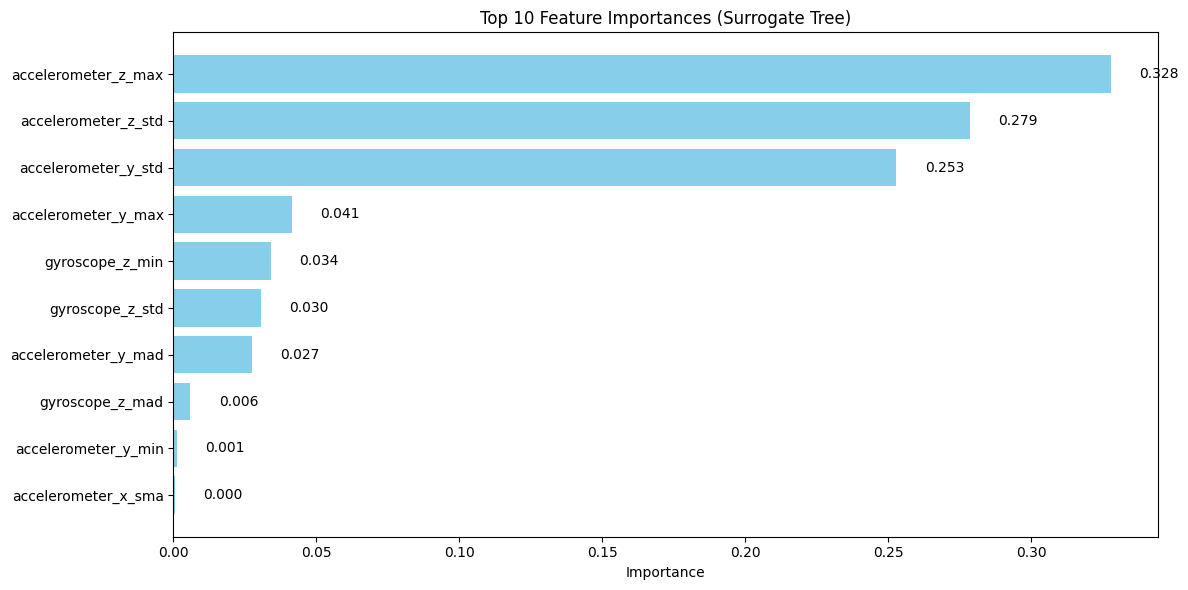

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# We assume you already have:
# - a trained DecisionTreeClassifier called df_surrogate
# - your features list called features

# Get feature importances from the already-trained surrogate
importances = df_surrogate.feature_importances_
indices = np.argsort(importances)[::-1]  # sort descending

# Take top 10
top_n = 10
top_indices = indices[:top_n]
top_features = [features[i] for i in top_indices]
top_importances = importances[top_indices]

# Plot with importance values
plt.figure(figsize=(12,6))
bars = plt.barh(range(top_n), top_importances[::-1], color='skyblue')
plt.yticks(range(top_n), top_features[::-1])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances (Surrogate Tree)')

# Add importance values at the end of each bar
for i, b in enumerate(bars):
    width = b.get_width()
    plt.text(width + 0.01, b.get_y() + b.get_height()/2,
             f"{top_importances[::-1][i]:.3f}",
             va='center')

plt.tight_layout()
plt.show()

In [25]:
import pandas as pd
import numpy as np

# Get feature importances from the already-trained surrogate
importances = df_surrogate.feature_importances_

# Build a DataFrame of all features with their importances
df_baseline_importance = pd.DataFrame({
    'feature': features,
    'importance': importances
})

# Sort descending
df_baseline_importance = df_baseline_importance.sort_values(
    by='importance', ascending=False
).reset_index(drop=True)

# If you only want top 10:
df_baseline_top10 = df_baseline_importance.head(10)

# Display
print(df_baseline_top10)

               feature  importance
0  accelerometer_z_max    0.327872
1  accelerometer_z_std    0.278566
2  accelerometer_y_std    0.252757
3  accelerometer_y_max    0.041412
4      gyroscope_z_min    0.034010
5      gyroscope_z_std    0.030489
6  accelerometer_y_mad    0.027456
7      gyroscope_z_mad    0.005934
8  accelerometer_y_min    0.001083
9  accelerometer_x_sma    0.000421


**Base line statictsics from ground truth**
---

In [26]:
import pandas as pd

# --- config ---
block_size = 50
selected_cols = [
    'accelerometer_x_mean','accelerometer_x_var','accelerometer_x_std',
    'accelerometer_y_mean','accelerometer_y_var','accelerometer_y_std',
    'accelerometer_z_mean','accelerometer_z_var','accelerometer_z_std',
    'gyroscope_x_mean','gyroscope_x_var','gyroscope_x_std',
    'gyroscope_y_mean','gyroscope_y_var','gyroscope_y_std',
    'gyroscope_z_mean','gyroscope_z_var','gyroscope_z_std'
]

# Make a copy; assign block index
df_tmp = df_nodrift.copy()
df_tmp['block'] = df_tmp.index // block_size

# Filter to only available columns
cols_to_use = [c for c in selected_cols if c in df_tmp.columns]
if len(cols_to_use) < len(selected_cols):
    print("Warning: some selected columns missing and skipped")

# Compute mean, var, std per block for the selected columns
df_baseline_stats = (
    df_tmp
    .groupby('block')[cols_to_use]
    .agg(['mean','var','std'])
)

# Flatten the MultiIndex columns
df_baseline_stats.columns = [
    f"{col}_{stat}" for col, stat in df_baseline_stats.columns
]

# Reset index so 'block' becomes a column
df_baseline_stats = df_baseline_stats.reset_index()

# Now df_baseline_stats has one row per 6 000-row block


df_baseline_stats.to_csv("df_baseline_stats.csv")
df_baseline_stats

,block,accelerometer_x_mean_mean,accelerometer_x_mean_var,accelerometer_x_mean_std,accelerometer_x_std_mean,accelerometer_x_std_var,accelerometer_x_std_std,accelerometer_y_mean_mean,accelerometer_y_mean_var,accelerometer_y_mean_std,...,gyroscope_y_mean_std,gyroscope_y_std_mean,gyroscope_y_std_var,gyroscope_y_std_std,gyroscope_z_mean_mean,gyroscope_z_mean_var,gyroscope_z_mean_std,gyroscope_z_std_mean,gyroscope_z_std_var,gyroscope_z_std_std
0,0,0.240303,0.880679,0.938445,-0.041462,1.021871,1.010876,-0.113114,1.153845,1.074172,...,0.829040,-0.003405,1.161637,1.077793,-0.138304,0.874010,0.934885,-0.159756,0.708265,0.841585
1,1,-0.118792,1.145621,1.070337,0.122060,1.607822,1.267999,0.164479,1.005699,1.002846,...,1.184949,0.163806,1.280543,1.131611,0.092642,0.884840,0.940659,0.083736,1.337586,1.156541
2,2,-0.172385,0.767719,0.876196,0.184838,1.116024,1.056420,-0.070193,1.239932,1.113523,...,1.079160,0.088931,0.892928,0.944949,-0.239944,1.234991,1.111302,0.177848,1.163928,1.078855
3,3,-0.076301,0.543047,0.736917,0.006184,0.926004,0.962291,-0.029066,1.091629,1.044811,...,1.033727,-0.097040,0.970363,0.985070,0.003542,0.922094,0.960257,-0.126275,0.857653,0.926096
4,4,-0.000319,1.191020,1.091339,0.103334,1.241855,1.114385,0.107726,1.522634,1.233951,...,1.035138,0.137092,1.645884,1.282920,-0.161715,0.793980,0.891056,0.070545,1.270195,1.127029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1195,-0.066169,0.862088,0.928487,0.131633,1.198173,1.094611,-0.292174,1.382758,1.175907,...,1.136229,0.069691,0.880568,0.938386,-0.044772,1.004261,1.002128,0.134411,1.085345,1.041799
1196,1196,0.085570,1.790338,1.338035,-0.133436,0.964963,0.982325,-0.084010,0.888449,0.942576,...,1.050514,-0.175468,0.723632,0.850666,0.046394,0.831377,0.911799,-0.184814,0.876798,0.936375
1197,1197,-0.040105,0.912422,0.955208,0.174467,1.478390,1.215891,0.188862,0.875765,0.935823,...,0.803793,0.142433,1.349997,1.161894,0.128372,1.007839,1.003912,0.154634,1.040462,1.020030
1198,1198,0.087796,1.386688,1.177577,0.136510,1.599861,1.264856,0.221795,0.929070,0.963883,...,0.904533,-0.013303,1.143300,1.069252,-0.073012,0.920248,0.959296,0.062836,1.499345,1.224478


In [27]:
# Compute DES per block
des_values = []
for idx, row in df_baseline_stats.iterrows():
    total = 0.0
    for _, feat_row in df_baseline_top10.iterrows():
        feature_name = feat_row["feature"]
        importance = feat_row["importance"]

        # Find all columns in df_baseline that start with this feature
        matching_cols = [c for c in df_baseline_stats.columns if c.startswith(feature_name)]
        for mc in matching_cols:
            total += importance * row[mc]

    des_values.append(total)

# Add DES column
df_baseline_stats["DES"] = des_values

# Show results
print("recurrent_drift", df_baseline_stats[["block", "DES"]])

recurrent_drift       block       DES
0         0  1.011350
1         1  1.912684
2         2  1.592349
3         3  0.968085
4         4  1.666439
...     ...       ...
1195   1195  0.818393
1196   1196  1.093731
1197   1197  1.246335
1198   1198  2.094954
1199   1199  1.514640

[1200 rows x 2 columns]


**New Data Statictsics**
---

In [28]:
import pandas as pd

# --- config ---
block_size = 50  # size of each chunk
selected_cols = [
    'accelerometer_x_mean','accelerometer_x_var','accelerometer_x_std',
    'accelerometer_y_mean','accelerometer_y_var','accelerometer_y_std',
    'accelerometer_z_mean','accelerometer_z_var','accelerometer_z_std',
    'gyroscope_x_mean','gyroscope_x_var','gyroscope_x_std',
    'gyroscope_y_mean','gyroscope_y_var','gyroscope_y_std',
    'gyroscope_z_mean','gyroscope_z_var','gyroscope_z_std'
]

# --- load/prepare data ---
# Combine all drift datasets into one
df_all = pd.concat(
    [df_sudden_type1, df_sudden_type2, df_recurrent],
    axis=0,
    ignore_index=True
)

# Assign block IDs
df_all['block'] = df_all.index // block_size

# Filter to only available columns (skip any missing ones gracefully)
cols_to_use = [c for c in selected_cols if c in df_all.columns]
if len(cols_to_use) < len(selected_cols):
    print("Warning: some selected columns missing and skipped")

# Compute mean/var/std per block for the selected columns
df_all_stats = (
    df_all
    .groupby('block')[cols_to_use]
    .agg(['mean','var','std'])
)

# Flatten the MultiIndex columns for cleaner names
df_all_stats.columns = [
    f"{col}_{stat}" for col, stat in df_all_stats.columns
]

# Reset index so 'block' becomes a column
df_all_stats = df_all_stats.reset_index()

# Save to CSV
df_all_stats.to_csv("df_all_drifts.csv", index=False)

print("✅ Combined drift statistics saved to df_all_drifts.csv")

✅ Combined drift statistics saved to df_all_drifts.csv


In [29]:
df_all_stats

,block,accelerometer_x_mean_mean,accelerometer_x_mean_var,accelerometer_x_mean_std,accelerometer_x_std_mean,accelerometer_x_std_var,accelerometer_x_std_std,accelerometer_y_mean_mean,accelerometer_y_mean_var,accelerometer_y_mean_std,...,gyroscope_y_mean_std,gyroscope_y_std_mean,gyroscope_y_std_var,gyroscope_y_std_std,gyroscope_z_mean_mean,gyroscope_z_mean_var,gyroscope_z_mean_std,gyroscope_z_std_mean,gyroscope_z_std_var,gyroscope_z_std_std
0,0,0.240303,0.880679,0.938445,-0.041462,1.021871,1.010876,-0.113114,1.153845,1.074172,...,0.829040,-0.003405,1.161637,1.077793,-0.138304,0.874010,0.934885,-0.159756,0.708265,0.841585
1,1,-0.118792,1.145621,1.070337,0.122060,1.607822,1.267999,0.164479,1.005699,1.002846,...,1.184949,0.163806,1.280543,1.131611,0.092642,0.884840,0.940659,0.083736,1.337586,1.156541
2,2,-0.172385,0.767719,0.876196,0.184838,1.116024,1.056420,-0.070193,1.239932,1.113523,...,1.079160,0.088931,0.892928,0.944949,-0.239944,1.234991,1.111302,0.177848,1.163928,1.078855
3,3,-0.076301,0.543047,0.736917,0.006184,0.926004,0.962291,-0.029066,1.091629,1.044811,...,1.033727,-0.097040,0.970363,0.985070,0.003542,0.922094,0.960257,-0.126275,0.857653,0.926096
4,4,-0.000319,1.191020,1.091339,0.103334,1.241855,1.114385,0.107726,1.522634,1.233951,...,1.035138,0.137092,1.645884,1.282920,-0.161715,0.793980,0.891056,0.070545,1.270195,1.127029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,3595,5.084007,30.299647,5.504511,5.719861,31.812834,5.640287,-4.782856,30.220970,5.497360,...,6.596062,-5.802143,41.213289,6.419758,-3.545096,32.616969,5.711127,5.580636,54.869404,7.407388
3596,3596,5.764280,55.735562,7.465625,5.204006,45.574279,6.750872,-4.743979,39.901177,6.316738,...,5.977509,-5.325693,39.866635,6.314003,-6.283171,31.417921,5.605169,3.781797,28.407199,5.329840
3597,3597,4.699295,52.300243,7.231891,5.376885,36.367113,6.030515,-4.871091,24.050661,4.904147,...,4.545335,-3.967714,38.801393,6.229076,-4.483531,43.683440,6.609345,6.832979,38.318734,6.190213
3598,3598,6.596273,53.710448,7.328741,6.259389,44.434742,6.665939,-6.477835,35.317432,5.942847,...,5.338250,-4.396350,31.810475,5.640078,-5.069411,44.569548,6.676043,6.982302,28.771561,5.363913


In [30]:
import pandas as pd
import numpy as np
from scipy.linalg import sqrtm
# Load your files
df_baseline = pd.read_csv('/content/df_baseline_stats.csv')
df_incremental = pd.read_csv('/content/df_all_drifts.csv')
df_baseline

,Unnamed: 0,block,accelerometer_x_mean_mean,accelerometer_x_mean_var,accelerometer_x_mean_std,accelerometer_x_std_mean,accelerometer_x_std_var,accelerometer_x_std_std,accelerometer_y_mean_mean,accelerometer_y_mean_var,...,gyroscope_y_mean_std,gyroscope_y_std_mean,gyroscope_y_std_var,gyroscope_y_std_std,gyroscope_z_mean_mean,gyroscope_z_mean_var,gyroscope_z_mean_std,gyroscope_z_std_mean,gyroscope_z_std_var,gyroscope_z_std_std
0,0,0,0.240303,0.880679,0.938445,-0.041462,1.021871,1.010876,-0.113114,1.153845,...,0.829040,-0.003405,1.161637,1.077793,-0.138304,0.874010,0.934885,-0.159756,0.708265,0.841585
1,1,1,-0.118792,1.145621,1.070337,0.122060,1.607822,1.267999,0.164479,1.005699,...,1.184949,0.163806,1.280543,1.131611,0.092642,0.884840,0.940659,0.083736,1.337586,1.156541
2,2,2,-0.172385,0.767719,0.876196,0.184838,1.116024,1.056420,-0.070193,1.239932,...,1.079160,0.088931,0.892928,0.944949,-0.239944,1.234991,1.111302,0.177848,1.163928,1.078855
3,3,3,-0.076301,0.543047,0.736917,0.006184,0.926004,0.962291,-0.029066,1.091629,...,1.033727,-0.097040,0.970363,0.985070,0.003542,0.922094,0.960257,-0.126275,0.857653,0.926096
4,4,4,-0.000319,1.191020,1.091339,0.103334,1.241855,1.114385,0.107726,1.522634,...,1.035138,0.137092,1.645884,1.282920,-0.161715,0.793980,0.891056,0.070545,1.270195,1.127029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1195,1195,-0.066169,0.862088,0.928487,0.131633,1.198173,1.094611,-0.292174,1.382758,...,1.136229,0.069691,0.880568,0.938386,-0.044772,1.004261,1.002128,0.134411,1.085345,1.041799
1196,1196,1196,0.085570,1.790338,1.338035,-0.133436,0.964963,0.982325,-0.084010,0.888449,...,1.050514,-0.175468,0.723632,0.850666,0.046394,0.831377,0.911799,-0.184814,0.876798,0.936375
1197,1197,1197,-0.040105,0.912422,0.955208,0.174467,1.478390,1.215891,0.188862,0.875765,...,0.803793,0.142433,1.349997,1.161894,0.128372,1.007839,1.003912,0.154634,1.040462,1.020030
1198,1198,1198,0.087796,1.386688,1.177577,0.136510,1.599861,1.264856,0.221795,0.929070,...,0.904533,-0.013303,1.143300,1.069252,-0.073012,0.920248,0.959296,0.062836,1.499345,1.224478


In [31]:
df_incremental = pd.read_csv('/content/df_all_drifts.csv')
df_incremental

,block,accelerometer_x_mean_mean,accelerometer_x_mean_var,accelerometer_x_mean_std,accelerometer_x_std_mean,accelerometer_x_std_var,accelerometer_x_std_std,accelerometer_y_mean_mean,accelerometer_y_mean_var,accelerometer_y_mean_std,...,gyroscope_y_mean_std,gyroscope_y_std_mean,gyroscope_y_std_var,gyroscope_y_std_std,gyroscope_z_mean_mean,gyroscope_z_mean_var,gyroscope_z_mean_std,gyroscope_z_std_mean,gyroscope_z_std_var,gyroscope_z_std_std
0,0,0.240303,0.880679,0.938445,-0.041462,1.021871,1.010876,-0.113114,1.153845,1.074172,...,0.829040,-0.003405,1.161637,1.077793,-0.138304,0.874010,0.934885,-0.159756,0.708265,0.841585
1,1,-0.118792,1.145621,1.070337,0.122060,1.607822,1.267999,0.164479,1.005699,1.002846,...,1.184949,0.163806,1.280543,1.131611,0.092642,0.884840,0.940659,0.083736,1.337586,1.156541
2,2,-0.172385,0.767719,0.876196,0.184838,1.116024,1.056420,-0.070193,1.239932,1.113523,...,1.079160,0.088931,0.892928,0.944949,-0.239944,1.234991,1.111302,0.177848,1.163928,1.078855
3,3,-0.076301,0.543047,0.736917,0.006184,0.926004,0.962291,-0.029066,1.091629,1.044811,...,1.033727,-0.097040,0.970363,0.985070,0.003542,0.922094,0.960257,-0.126275,0.857653,0.926096
4,4,-0.000319,1.191020,1.091339,0.103334,1.241855,1.114385,0.107726,1.522634,1.233951,...,1.035138,0.137092,1.645884,1.282920,-0.161715,0.793980,0.891056,0.070545,1.270195,1.127029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,3595,5.084007,30.299647,5.504511,5.719861,31.812834,5.640287,-4.782856,30.220970,5.497360,...,6.596062,-5.802143,41.213289,6.419758,-3.545096,32.616969,5.711127,5.580636,54.869404,7.407388
3596,3596,5.764280,55.735562,7.465625,5.204006,45.574279,6.750872,-4.743979,39.901177,6.316738,...,5.977509,-5.325693,39.866635,6.314003,-6.283171,31.417921,5.605169,3.781797,28.407199,5.329840
3597,3597,4.699295,52.300243,7.231891,5.376885,36.367113,6.030515,-4.871091,24.050661,4.904147,...,4.545335,-3.967714,38.801393,6.229076,-4.483531,43.683440,6.609345,6.832979,38.318734,6.190213
3598,3598,6.596273,53.710448,7.328741,6.259389,44.434742,6.665939,-6.477835,35.317432,5.942847,...,5.338250,-4.396350,31.810475,5.640078,-5.069411,44.569548,6.676043,6.982302,28.771561,5.363913


In [32]:
import pandas as pd
import numpy as np

# Load
df_baseline = pd.read_csv('/content/df_baseline_stats.csv')
df_incremental = pd.read_csv('/content/df_all_drifts.csv')

baseline_row = df_baseline.mean(numeric_only=True)

cols = [c for c in df_baseline.columns if c != 'block']
base_features = sorted(set(col.rsplit('_', 1)[0] for col in cols))

def get_pair(basename, row, is_baseline):
    """
    For a basename like 'accelerometer_x_mean' or 'accelerometer_x_std',
    return (mu, sigma) pulled from either baseline_row (is_baseline=True)
    or an incremental row (is_baseline=False), using sensible fallbacks.
    """
    if is_baseline:
        mu = baseline_row.get(f"{basename}_mean", np.nan)
        sig = baseline_row.get(f"{basename}_std", np.nan)
        if pd.isna(sig):
            sig = np.sqrt(np.abs(baseline_row.get(f"{basename}_var", np.nan)))
        return mu, sig
    else:
        # incremental side:
        # the 'mean' of this statistic is usually just the column itself
        mu = row.get(basename, np.nan)

        # prefer a matching std-of-this-statistic if it exists
        sig = row.get(f"{basename}_std", np.nan)
        if pd.isna(sig):
            # try var of this statistic
            var_val = row.get(f"{basename}_var", np.nan)
            if not pd.isna(var_val):
                sig = np.sqrt(np.abs(var_val))

        # as a last resort: if basename ends with '_mean', try mapping to its sibling '_std'
        if pd.isna(sig) and basename.endswith('_mean'):
            sibling = basename[:-5] + '_std'  # replace '_mean' -> '_std'
            sig = row.get(sibling, np.nan)

        return mu, sig

records = []
for _, inc_row in df_incremental.iterrows():
    block_id = inc_row['block'] if 'block' in inc_row else _
    out = {'block': block_id}
    for base in base_features:
        mu_b, sig_b = get_pair(base, baseline_row, True)
        mu_n, sig_n = get_pair(base, inc_row, False)

        # distance in whatever dimensions we actually have
        terms = []
        if not pd.isna(mu_b) and not pd.isna(mu_n):
            terms.append((mu_b - mu_n)**2)
        if not pd.isna(sig_b) and not pd.isna(sig_n):
            terms.append((sig_b - sig_n)**2)

        d = np.sqrt(sum(terms)) if terms else np.nan
        out[base] = d
    records.append(out)

df_frechet_vector = pd.DataFrame(records)
df_frechet_vector

,block,Unnamed: 0,accelerometer_x_mean,accelerometer_x_std,accelerometer_y_mean,accelerometer_y_std,accelerometer_z_mean,accelerometer_z_std,gyroscope_x_mean,gyroscope_x_std,gyroscope_y_mean,gyroscope_y_std,gyroscope_z_mean,gyroscope_z_std
0,0.0,NaN,0.062521,0.021158,0.084300,0.066335,0.140121,0.007091,0.009154,0.089703,0.158626,0.089999,0.051153,0.152106
1,1.0,NaN,0.069371,0.278281,0.012974,0.198938,0.001870,0.545776,0.017573,0.068124,0.197284,0.143817,0.045379,0.162849
2,2.0,NaN,0.124770,0.066703,0.123651,0.102741,0.047083,0.310049,0.195711,0.058216,0.091495,0.042845,0.125263,0.085163
3,3.0,NaN,0.264049,0.027427,0.054939,0.047450,0.055607,0.095131,0.131110,0.253331,0.046061,0.002724,0.025781,0.067596
4,4.0,NaN,0.090372,0.124667,0.244079,0.264549,0.186942,0.275784,0.031356,0.238301,0.047472,0.295126,0.094983,0.133338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,3595.0,NaN,4.503545,4.650569,4.507489,5.786786,5.431771,5.495918,4.679929,4.597336,5.608397,5.431964,4.725089,6.413697
3596,3596.0,NaN,6.464659,5.761154,5.326866,6.366560,4.765498,5.420952,4.217374,6.520230,4.989843,5.326209,4.619131,4.336149
3597,3597.0,NaN,6.230925,5.040797,3.914276,5.279764,5.289245,5.434438,7.225175,5.860468,3.557670,5.241282,5.623307,5.196521
3598,3598.0,NaN,6.327775,5.676221,4.952976,5.723204,4.167542,6.187284,5.790144,5.814928,4.350585,4.652284,5.690005,4.370221


In [33]:
import pandas as pd
import numpy as np
from scipy.linalg import sqrtm
# Load your files
df_baseline = pd.read_csv('/content/df_baseline_stats.csv')
df_incremental = pd.read_csv('/content/df_all_drifts.csv')

# Baseline = first row (your reference stats)
baseline_row = df_baseline.mean()

# Prepare list of all features: everything except 'block'
cols = [c for c in df_baseline.columns if c != 'block']

# Group the columns by base feature:
# e.g. accelerometer_x_mean, accelerometer_x_std, accelerometer_x_var
base_features = sorted(set(col.rsplit('_',1)[0] for col in cols))

records = []
for idx, inc_row in df_incremental.iterrows():
    block_id = inc_row['block'] if 'block' in inc_row else idx
    row_result = {'block': block_id}
    for base in base_features:
        # Grab mean/std for baseline and incremental for this feature
        mean_b = float(baseline_row.get(f"{base}_mean", np.nan))
        std_b  = float(baseline_row.get(f"{base}_std", np.sqrt(abs(baseline_row.get(f"{base}_var",0)))))
        mean_n = float(inc_row.get(f"{base}_mean", np.nan))
        std_n  = float(inc_row.get(f"{base}_std", np.sqrt(abs(inc_row.get(f"{base}_var",0)))))

        # Fréchet/Wasserstein-2 distance in 1-D
        d = np.sqrt((mean_b - mean_n)**2 + (std_b - std_n)**2)
        row_result[base] = d
    records.append(row_result)

df_frechet_vector = pd.DataFrame(records)

df_frechet_vector

,block,Unnamed: 0,accelerometer_x_mean,accelerometer_x_std,accelerometer_y_mean,accelerometer_y_std,accelerometer_z_mean,accelerometer_z_std,gyroscope_x_mean,gyroscope_x_std,gyroscope_y_mean,gyroscope_y_std,gyroscope_z_mean,gyroscope_z_std
0,0.0,NaN,0.247720,0.047130,0.140015,0.072017,0.256715,0.030871,0.035452,0.152345,0.184008,0.090008,0.145667,0.219930
1,1.0,NaN,0.138085,0.303612,0.166306,0.209825,0.130439,0.625599,0.053135,0.108858,0.242043,0.219577,0.104881,0.183533
2,2.0,NaN,0.213289,0.195892,0.141538,0.197388,0.063023,0.409025,0.216129,0.144558,0.128005,0.100627,0.268978,0.198006
3,3.0,NaN,0.275020,0.027979,0.061548,0.056834,0.057266,0.115614,0.141704,0.318112,0.167493,0.094961,0.026352,0.142430
4,4.0,NaN,0.090377,0.161510,0.267330,0.311597,0.229372,0.319754,0.302892,0.255720,0.048053,0.326311,0.185898,0.151276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,3595.0,NaN,6.791386,7.371373,6.571190,7.555015,8.260949,7.611145,6.468607,6.390475,6.552602,7.946478,5.905980,8.502302
3596,3596.0,NaN,8.660935,7.763104,7.132203,7.642791,6.796081,7.176830,6.666685,9.031255,6.093911,7.530534,7.796830,5.754219
3597,3597.0,NaN,7.803982,7.369770,6.247898,6.798274,7.337492,7.625780,10.091734,8.310429,6.394584,6.572442,7.190721,8.585210
3598,3598.0,NaN,9.140219,8.449336,8.153356,7.464952,7.233365,8.259650,7.780639,8.439959,6.194625,6.399454,7.619428,8.237964


In [34]:
df_baseline_top10

,feature,importance
0,accelerometer_z_max,0.327872
1,accelerometer_z_std,0.278566
2,accelerometer_y_std,0.252757
3,accelerometer_y_max,0.041412
4,gyroscope_z_min,0.034010
5,gyroscope_z_std,0.030489
6,accelerometer_y_mad,0.027456
7,gyroscope_z_mad,0.005934
8,accelerometer_y_min,0.001083
9,accelerometer_x_sma,0.000421


**Model-Aware Drift Exposure Score (DES)**
---

In [35]:
import pandas as pd

# Convert top-10 importance DF into dict
importance_dict = dict(zip(df_baseline_top10['feature'], df_baseline_top10['importance']))

# Copy the Frechet vector DF
df_des_gradual = df_frechet_vector.copy()

# Compute DES per block
des_values = []
for idx, row in df_des_gradual.iterrows():
    total = 0.0
    for feature_name, importance in importance_dict.items():
        # Find all matching columns (prefix match)
        matching_cols = [c for c in df_des_gradual.columns if c.startswith(feature_name)]
        for mc in matching_cols:
            total += importance * row[mc]
    des_values.append(total)

# Store DES
df_des_gradual['DES'] = des_values

# Show results
print("recurrent_drift", df_des_gradual[['block','DES']])


recurrent_drift        block       DES
0        0.0  0.033508
1        1.0  0.232901
2        2.0  0.169869
3        3.0  0.050914
4        4.0  0.172443
...      ...       ...
3595  3595.0  4.289013
3596  3596.0  4.106427
3597  3597.0  4.104347
3598  3598.0  4.438841
3599  3599.0  4.082584

[3600 rows x 2 columns]


<Axes: >

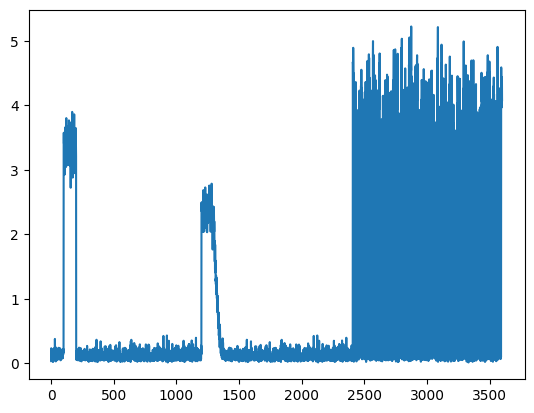

In [36]:
df_des_gradual["DES"].plot()

In [37]:
df_des_gradual

,block,Unnamed: 0,accelerometer_x_mean,accelerometer_x_std,accelerometer_y_mean,accelerometer_y_std,accelerometer_z_mean,accelerometer_z_std,gyroscope_x_mean,gyroscope_x_std,gyroscope_y_mean,gyroscope_y_std,gyroscope_z_mean,gyroscope_z_std,DES
0,0.0,NaN,0.247720,0.047130,0.140015,0.072017,0.256715,0.030871,0.035452,0.152345,0.184008,0.090008,0.145667,0.219930,0.033508
1,1.0,NaN,0.138085,0.303612,0.166306,0.209825,0.130439,0.625599,0.053135,0.108858,0.242043,0.219577,0.104881,0.183533,0.232901
2,2.0,NaN,0.213289,0.195892,0.141538,0.197388,0.063023,0.409025,0.216129,0.144558,0.128005,0.100627,0.268978,0.198006,0.169869
3,3.0,NaN,0.275020,0.027979,0.061548,0.056834,0.057266,0.115614,0.141704,0.318112,0.167493,0.094961,0.026352,0.142430,0.050914
4,4.0,NaN,0.090377,0.161510,0.267330,0.311597,0.229372,0.319754,0.302892,0.255720,0.048053,0.326311,0.185898,0.151276,0.172443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,3595.0,NaN,6.791386,7.371373,6.571190,7.555015,8.260949,7.611145,6.468607,6.390475,6.552602,7.946478,5.905980,8.502302,4.289013
3596,3596.0,NaN,8.660935,7.763104,7.132203,7.642791,6.796081,7.176830,6.666685,9.031255,6.093911,7.530534,7.796830,5.754219,4.106427
3597,3597.0,NaN,7.803982,7.369770,6.247898,6.798274,7.337492,7.625780,10.091734,8.310429,6.394584,6.572442,7.190721,8.585210,4.104347
3598,3598.0,NaN,9.140219,8.449336,8.153356,7.464952,7.233365,8.259650,7.780639,8.439959,6.194625,6.399454,7.619428,8.237964,4.438841


In [38]:
df_des_gradual.to_csv("df_des_gradual.csv")

In [78]:
import pandas as pd
import numpy as np

# Threshold for scaled values (0–1 range)
threshold_scaled = 0.3

# Step 1: Assign groups of 5 blocks
df_des_gradual["block_group"] = (df_des_gradual["block"] // 5).astype(int)

# Step 2: Aggregate by group
results = []
for group_id, subset in df_des_gradual.groupby("block_group"):
    avg_des = subset["DES"].mean()
    results.append({
        "block_range": f"{subset['block'].min():.0f}-{subset['block'].max():.0f}",
        "total_blocks": len(subset),
        "avg_DES": avg_des
    })

df_summary = pd.DataFrame(results)

# Step 3: Scale avg_DES to [0, 1] range
min_val = df_summary["avg_DES"].min()
max_val = df_summary["avg_DES"].max()
df_summary["avg_DES_scaled"] = (df_summary["avg_DES"] - min_val) / (max_val - min_val)

# Step 4: Final drift decision based on scaled threshold
df_summary["final_drift"] = np.where(df_summary["avg_DES_scaled"] > threshold_scaled,
                                     "REAL_DRIFT", "PSEUDO_DRIFT")

print(df_summary)


    block_range  total_blocks   avg_DES  avg_DES_scaled   final_drift
0           0-4             5  0.131927        0.016159  PSEUDO_DRIFT
1           5-9             5  0.158154        0.022002  PSEUDO_DRIFT
2         10-14             5  0.096767        0.008326  PSEUDO_DRIFT
3         15-19             5  0.092383        0.007349  PSEUDO_DRIFT
4         20-24             5  0.153328        0.020927  PSEUDO_DRIFT
..          ...           ...       ...             ...           ...
715   3575-3579             5  3.140423        0.686415    REAL_DRIFT
716   3580-3584             5  3.330821        0.728833    REAL_DRIFT
717   3585-3589             5  0.107962        0.010820  PSEUDO_DRIFT
718   3590-3594             5  2.668473        0.581270    REAL_DRIFT
719   3595-3599             5  4.204243        0.923420    REAL_DRIFT

[720 rows x 5 columns]


<Axes: >

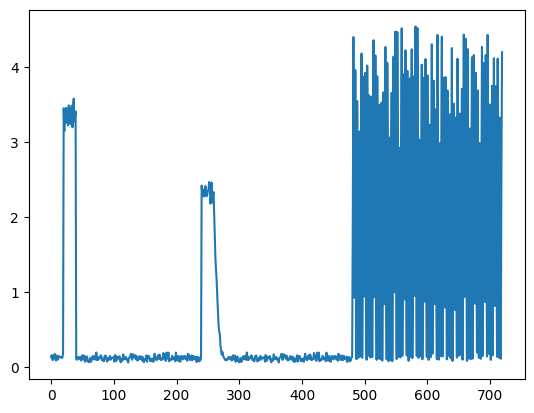

In [79]:
df_summary['avg_DES'].plot()

In [80]:
df_summary['final_drift'].value_counts()

,count
final_drift,
PSEUDO_DRIFT,527
REAL_DRIFT,193


In [81]:
df_all['block'].value_counts()

,count
block,
3583,50
3582,50
3581,50
3580,50
3579,50
...,...
4,50
3,50
2,50


In [43]:
df_all.to_csv("/content/drive/My Drive/Early Drift Detection/Drifted_HAR_data.csv")

In [44]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
# --- config ---
features = ['accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'gyroscope_x',
       'gyroscope_y', 'gyroscope_z', 'accelerometer_x_mean',
       'accelerometer_x_std', 'accelerometer_x_mad', 'accelerometer_x_max',
       'accelerometer_x_min', 'accelerometer_x_sma', 'accelerometer_y_mean',
       'accelerometer_y_std', 'accelerometer_y_mad', 'accelerometer_y_max',
       'accelerometer_y_min', 'accelerometer_y_sma', 'accelerometer_z_mean',
       'accelerometer_z_std', 'accelerometer_z_mad', 'accelerometer_z_max',
       'accelerometer_z_min', 'accelerometer_z_sma', 'gyroscope_x_mean',
       'gyroscope_x_std', 'gyroscope_x_mad', 'gyroscope_x_max',
       'gyroscope_x_min', 'gyroscope_x_sma', 'gyroscope_y_mean',
       'gyroscope_y_std', 'gyroscope_y_mad', 'gyroscope_y_max',
       'gyroscope_y_min', 'gyroscope_y_sma', 'gyroscope_z_mean',
       'gyroscope_z_std', 'gyroscope_z_mad', 'gyroscope_z_max',
       'gyroscope_z_min', 'gyroscope_z_sma']
target = 'activity'
num_classes = 5  # adjust to your actual number of activity classes
time_steps = len(features)
df_tmp=df_all
# --- evaluation over 5-block windows ---
accuracies = []
block_ids = sorted(df_tmp['block'].unique())

# process in chunks of 5 blocks at a time
for i in range(0, len(block_ids), 5):
    block_chunk = block_ids[i:i+5]
    df_chunk = df_tmp[df_tmp['block'].isin(block_chunk)]
    if df_chunk.empty:
        continue

    # prepare X and y
    X_chunk = df_chunk[features].values
    y_chunk = df_chunk[target].values

    # normalize
    X_chunk = scaler.transform(X_chunk)

    # reshape for CNN (samples, time_steps, channels)
    X_chunk = X_chunk.reshape(-1, time_steps, 1)

    # one-hot encode y
    y_chunk_cat = to_categorical(y_chunk, num_classes=num_classes)

    # evaluate model on this chunk
    loss, accuracy = model.evaluate(X_chunk, y_chunk_cat, verbose=0)
    accuracies.append({
        'block_range': f"{block_chunk[0]}-{block_chunk[-1]}",
        'accuracy': accuracy
    })
# convert to DataFrame
df_accuracies = pd.DataFrame(accuracies)
# save or inspect
df_accuracies.to_csv('blockwise_accuracies.csv', index=False)
print(df_accuracies)

    block_range  accuracy
0           0-4     0.676
1           5-9     0.684
2         10-14     0.680
3         15-19     0.652
4         20-24     0.700
..          ...       ...
715   3575-3579     0.272
716   3580-3584     0.336
717   3585-3589     0.704
718   3590-3594     0.340
719   3595-3599     0.204

[720 rows x 2 columns]


In [45]:
df_accuracies

,block_range,accuracy
0,0-4,0.676
1,5-9,0.684
2,10-14,0.680
3,15-19,0.652
4,20-24,0.700
...,...,...
715,3575-3579,0.272
716,3580-3584,0.336
717,3585-3589,0.704
718,3590-3594,0.340


In [46]:
import numpy as np
# Assume df is your dataframe with 'accuracy'
df_accuracies["Ground truth"] = np.where(df_accuracies["accuracy"] > 0.50, "PSEUDO_DRIFT", "REAL_DRIFT")
df_accuracies

,block_range,accuracy,Ground truth
0,0-4,0.676,PSEUDO_DRIFT
1,5-9,0.684,PSEUDO_DRIFT
2,10-14,0.680,PSEUDO_DRIFT
3,15-19,0.652,PSEUDO_DRIFT
4,20-24,0.700,PSEUDO_DRIFT
...,...,...,...
715,3575-3579,0.272,REAL_DRIFT
716,3580-3584,0.336,REAL_DRIFT
717,3585-3589,0.704,PSEUDO_DRIFT
718,3590-3594,0.340,REAL_DRIFT


<Axes: >

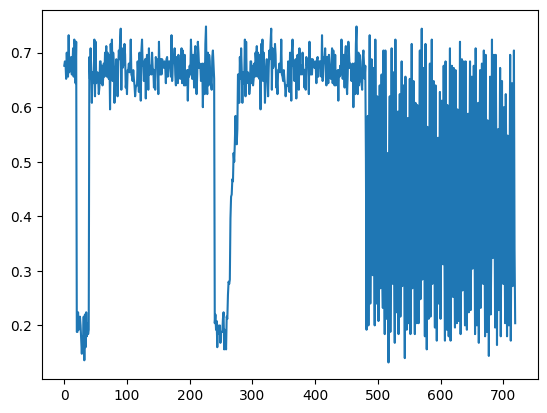

In [47]:
df_accuracies["accuracy"].plot()

In [48]:
df_accuracies['Ground truth'].value_counts()

,count
Ground truth,
PSEUDO_DRIFT,525
REAL_DRIFT,195


In [82]:
df_summary["final_drift"].value_counts()

,count
final_drift,
PSEUDO_DRIFT,527
REAL_DRIFT,193


In [83]:
df_summary.to_csv("MPDD.csv")

In [51]:
df_accuracies.to_csv("Ground.csv")

In [52]:
df_summary

,block_range,total_blocks,avg_DES,avg_DES_scaled,final_drift
0,0-4,5,0.131927,0.016159,PSEUDO_DRIFT
1,5-9,5,0.158154,0.022002,PSEUDO_DRIFT
2,10-14,5,0.096767,0.008326,PSEUDO_DRIFT
3,15-19,5,0.092383,0.007349,PSEUDO_DRIFT
4,20-24,5,0.153328,0.020927,PSEUDO_DRIFT
...,...,...,...,...,...
715,3575-3579,5,3.140423,0.686415,REAL_DRIFT
716,3580-3584,5,3.330821,0.728833,REAL_DRIFT
717,3585-3589,5,0.107962,0.010820,PSEUDO_DRIFT
718,3590-3594,5,2.668473,0.581270,PSEUDO_DRIFT


In [53]:
df_accuracies

,block_range,accuracy,Ground truth
0,0-4,0.676,PSEUDO_DRIFT
1,5-9,0.684,PSEUDO_DRIFT
2,10-14,0.680,PSEUDO_DRIFT
3,15-19,0.652,PSEUDO_DRIFT
4,20-24,0.700,PSEUDO_DRIFT
...,...,...,...
715,3575-3579,0.272,REAL_DRIFT
716,3580-3584,0.336,REAL_DRIFT
717,3585-3589,0.704,PSEUDO_DRIFT
718,3590-3594,0.340,REAL_DRIFT


In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSVs
pred_df = pd.read_csv("MPDD.csv")
truth_df = pd.read_csv("Ground.csv")

# Merge on block_range
df = pd.merge(
    pred_df[["block_range", "final_drift"]],
    truth_df[["block_range", "Ground truth"]],
    on="block_range"
)

# Normalize labels
df["pred"] = df["final_drift"].str.upper()
df["true"] = df["Ground truth"].str.upper()

# Define confusion components
df["TP"] = ((df["pred"] == "REAL_DRIFT") & (df["true"] == "REAL_DRIFT")).astype(int)
df["FP"] = ((df["pred"] == "REAL_DRIFT") & (df["true"] == "PSEUDO_DRIFT")).astype(int)
df["TN"] = ((df["pred"] == "PSEUDO_DRIFT") & (df["true"] == "PSEUDO_DRIFT")).astype(int)
df["FN"] = ((df["pred"] == "PSEUDO_DRIFT") & (df["true"] == "REAL_DRIFT")).astype(int)

# Group into block windows (example: every 50 block_ranges)
df["group"] = (df.index // 50) * 50
summary = df.groupby("group")[["TP", "FP", "TN", "FN"]].sum().reset_index()
summary

,group,TP,FP,TN,FN
0,0,20,0,30,0
1,50,0,0,50,0
2,100,0,0,50,0
3,150,0,0,50,0
4,200,0,0,40,10
5,250,0,0,29,21
6,300,0,0,50,0
7,350,0,0,50,0
8,400,0,0,50,0
9,450,7,0,39,4


In [55]:
df_summary

,block_range,total_blocks,avg_DES,avg_DES_scaled,final_drift
0,0-4,5,0.131927,0.016159,PSEUDO_DRIFT
1,5-9,5,0.158154,0.022002,PSEUDO_DRIFT
2,10-14,5,0.096767,0.008326,PSEUDO_DRIFT
3,15-19,5,0.092383,0.007349,PSEUDO_DRIFT
4,20-24,5,0.153328,0.020927,PSEUDO_DRIFT
...,...,...,...,...,...
715,3575-3579,5,3.140423,0.686415,REAL_DRIFT
716,3580-3584,5,3.330821,0.728833,REAL_DRIFT
717,3585-3589,5,0.107962,0.010820,PSEUDO_DRIFT
718,3590-3594,5,2.668473,0.581270,PSEUDO_DRIFT


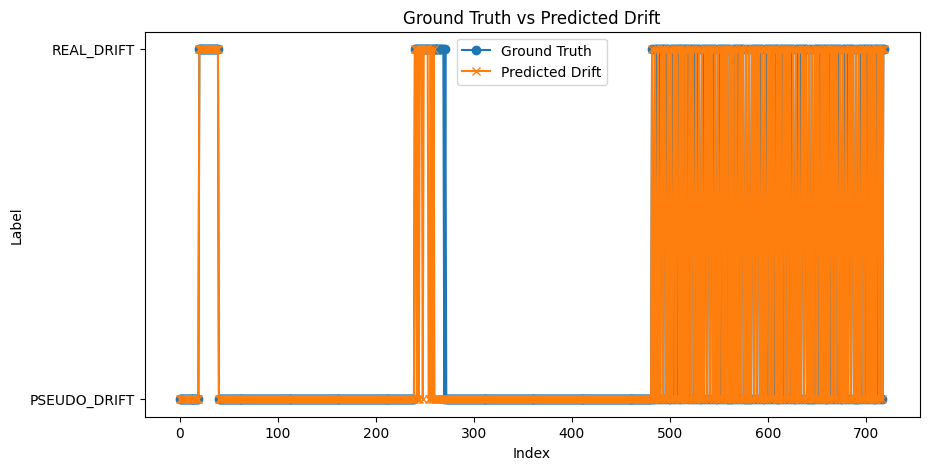

In [62]:
import matplotlib.pyplot as plt
y_true = df_accuracies["Ground truth"][:]
y_pred = df_summary["final_drift"][:]
plt.figure(figsize=(10,5))
plt.plot(y_true.values, label="Ground Truth", marker='o')
plt.plot(y_pred.values, label="Predicted Drift", marker='x')
plt.xlabel("Index")
plt.ylabel("Label")
plt.title("Ground Truth vs Predicted Drift")
plt.legend()
plt.show()

In [84]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
# Example: assume your dataframe has columns 'actual' and 'predicted'
y_true = df_accuracies["Ground truth"][:]
y_pred = df_summary["final_drift"][:]
# Basic metrics
acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average="weighted")   # use 'macro' or 'micro' if needed
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Detailed report (per class precision, recall, f1)
report = classification_report(y_true, y_pred)
print("Accuracy:", acc)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

Accuracy: 0.9777777777777777
F1 Score: 0.9777416277945461
Precision: 0.977724467691138
Recall: 0.9777777777777777
Confusion Matrix:
 [[518   7]
 [  9 186]]
Classification Report:
               precision    recall  f1-score   support

PSEUDO_DRIFT       0.98      0.99      0.98       525
  REAL_DRIFT       0.96      0.95      0.96       195

    accuracy                           0.98       720
   macro avg       0.97      0.97      0.97       720
weighted avg       0.98      0.98      0.98       720

